In [ ]:
@jit
def total_rho(U, G):
    """
    Computes the smooth robustness for the RURAMCA specification:
    (Eventual Ci) U_[0,50] (Eventual Di) AND (Collaborative Meetings)
    """
    # 1. Simulate trajectories for all agents
    # Xall shape: (num_agents, state_dim, N+1)
    Xall = vmap(simulate_agent_scan)(x0_list, U)
    t_idx = jnp.arange(N + 1)
    
    def agent_metrics(idx, Tc, Gc, rt, rg):
        # Extract position sequence for agent idx: (N+1, 2)
        pos = Xall[idx, :2, :].T 
        
        # --- A. Safety Constraints (Obstacles & Inter-agent) ---
        # Obstacles
        d_obs = jnp.sqrt(jnp.sum((pos[:, None, :] - O_centers[None, :, :])**2, axis=-1) + 1e-9) - r_obs
        m_obs = vmap(lambda v: smooth_min(v, G))(d_obs)
        
        # Inter-agent Collision Avoidance
        all_agent_pos_T = Xall[:, :2, :].transpose(2, 0, 1) # (N+1, num_agents, 2)
        dist_agents = jnp.sqrt(jnp.sum((pos[:, None, :] - all_agent_pos_T)**2, axis=-1) + 1e-9)
        # Mask self-collision
        dist_agents_masked = jnp.where((agent_range == idx)[None, :], 1e5, dist_agents - d_min)
        m_agents = vmap(lambda v: smooth_min(v, G))(dist_agents_masked)

        # --- B. Sequential Until Logic ---
        # Robustness to regions at every time step
        dist_to_Ci = jnp.sqrt(jnp.sum((pos - Tc)**2, axis=-1) + 1e-9)
        dist_to_Di = jnp.sqrt(jnp.sum((pos - Gc)**2, axis=-1) + 1e-9)

        # Pre-calculate Eventually robustness for all possible starting times t
        def get_eventual_Ci(t):
            mask = (t_idx >= t + ci_rel_low) & (t_idx <= t + ci_rel_high)
            return smooth_max(jnp.where(mask, rt - dist_to_Ci, -1e5), G)

        def get_eventual_Di(t):
            mask = (t_idx >= t + di_rel_low) & (t_idx <= t + di_rel_high)
            return smooth_max(jnp.where(mask, rg - dist_to_Di, -1e5), G)

        rho_Ci_at_t = vmap(get_eventual_Ci)(t_idx)
        rho_Di_at_t = vmap(get_eventual_Di)(t_idx)

        # Compute Until robustness for a specific transition time t_star
        def until_at_tstar(t_star):
            # 1. Right-hand side (Switch to Di goal)
            rhs = rho_Di_at_t[t_star]
            # 2. Left-hand side (Maintain Ci promise up to t_star)
            # Use a soft-min over the history of rho_Ci
            lhs_history = jnp.where(t_idx <= t_star, rho_Ci_at_t, 1e5)
            lhs = smooth_min(lhs_history, G)
            return smooth_min(jnp.array([rhs, lhs]), G)

        # Maximize over the transition window [0, 50]
        u_window = jnp.arange(until_low, until_high + 1)
        m_until = smooth_max(vmap(until_at_tstar)(u_window), G)
        
        # Conjunction of Safety and Sequential Task
        return smooth_min(jnp.array([
            smooth_min(m_obs, G), 
            smooth_min(m_agents, G), 
            m_until
        ]), G)

    # Compute robustness for each agent independently
    rhos_agents = vmap(agent_metrics)(agent_range, T_centers, G_centers, r_target, r_goal)
    
    # --- C. Collaborative Meeting Tasks ---
    def compute_group_rho(member_indices):
        mask = (member_indices != -1)
        # Use index 0 as a safe dummy for masked agents
        safe_idx = jnp.where(mask, member_indices, 0)
        group_pos = Xall[safe_idx, :2, :] 
        
        # Pairwise distances within the group
        diff = group_pos[:, None, :, :] - group_pos[None, :, :, :]
        dists = jnp.sqrt(jnp.sum(diff**2, axis=2) + 1e-9) 
        
        # Only consider valid pairs (no self-distance, no masked agents)
        pair_mask = mask[:, None] * mask[None, :] * (jnp.eye(3) == 0)
        
        # Max distance between any two members at time t (lower is better for meeting)
        max_dist_at_t = jnp.max(jnp.where(pair_mask[:, :, None], dists, 0.0), axis=(0, 1))
        rho_at_t = mu_meet - max_dist_at_t
        
        # Check if meeting happens at any point in the meet_window
        rho_window = jnp.where((t_idx >= meet_low) & (t_idx <= meet_high), rho_at_t, -1e5)
        return smooth_max(rho_window, G)

    # Compute robustness for each group
    rhos_groups = vmap(compute_group_rho)(meeting_groups_mat)
    
    # --- D. Global Conjunction ---
    # The mission is satisfied only if all agents AND all groups satisfy their specs
    return smooth_min(jnp.concatenate([rhos_agents, rhos_groups]), G)

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, vmap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import deque

# ===============================
# 1. Parameters & Setup
# ===============================
N, num_agents = 100, 10
dt = 1.0
Gamma = 1.0  # Start with a low Gamma for "Continuation"
alpha0, tol = 2.0, 1e-2
mu_meet = 0.25          
d_min = 0.01            
w_v, w_w = 1.0, 1.0   
maxIter, maxLineIters = 5000, 50
armijo_beta, armijo_c = 0.5, 0.5 # was 1e-4
stall_window, stall_tol = 15, 1e-6 
lam, global_iter = 1, 0

weights = jnp.array([w_v**2, w_w**2])
agent_range = jnp.arange(num_agents)

x0_list = jnp.array([
    [1.5, 10, 0], [1.5, 15, 0], [11.5, 10, 0], [13.5, 15, 0], [17, 7, 0],
    [31.5, 15, 0], [33.5, 10, 0], [36.5, 6, 0], [47.0, 10, 0], [47.0, 15, 0]
])

O_centers = jnp.array([[6.0, 10.0], [24.0, 10.0], [42.0, 10.0]])
r_obs = jnp.array([3.162, 3.162, 3.162])
T_centers = jnp.array([jnp.array([1.5, 1.5]) + k*jnp.array([5.0, 0.0]) for k in range(num_agents)])
G_centers = jnp.array([jnp.array([1.5, 19.0]) + k*jnp.array([5.0, 0.0]) for k in range(num_agents)])
r_target, r_goal = jnp.full(num_agents, 0.8), jnp.full(num_agents, 0.8)

meeting_groups_mat = jnp.array([
    [0, 1, 2], [2, 3, -1], [0, 4, -1], [3, 4, -1], [3, 6, -1],
    [4, 5, -1], [6, 7, -1], [5, 7, -1], [5, 8, -1], [8, 9, -1], [7, 9, -1]
])

t1_low, t1_high = 11, 51
g1_low, g1_high = max(1, N-30), N
meet_low, meet_high = 0, 70
# --- Until Transition Window ---
until_low, until_high = 1, 51

# --- Phase 1: Reach Ci (Relative to current time t) ---
# Goal: Visit Ci within 10 to 50 steps from "now"
ci_rel_low, ci_rel_high = 11, 51 

# --- Phase 2: Reach Di (Relative to transition time t*) ---
# Goal: Visit Di within 10 to 50 steps from the switch
di_rel_low, di_rel_high = N-30, N 


# ===============================
# 2. Differentiable Smooth Semantics
# ===============================
def smooth_min(vec, G):
    m = jnp.min(vec)
    return -(1/G) * (jnp.log(jnp.sum(jnp.exp(-G * (vec - m))) + 1e-6) - G * m)

def smooth_max(vec, G):
    m = jnp.max(vec)
    return (1/G) * (jnp.log(jnp.sum(jnp.exp(G * (vec - m))) + 1e-6) + G * m)

def step_unicycle(carry, u):
    x, y, th = carry
    next_state = jnp.array([x + dt*u[0]*jnp.cos(th), y + dt*u[0]*jnp.sin(th), th + dt*u[1]])
    return next_state, carry 

def simulate_agent_scan(x0, u_seq):
    last_state, states = lax.scan(step_unicycle, x0, u_seq.T)
    return jnp.vstack([states, last_state]).T

@jit
def total_rho(U, G):
    """
    Computes the smooth robustness for the RURAMCA specification:
    (Eventual Ci) U_[0,50] (Eventual Di) AND (Collaborative Meetings)
    """
    # 1. Simulate trajectories for all agents
    # Xall shape: (num_agents, state_dim, N+1)
    Xall = vmap(simulate_agent_scan)(x0_list, U)
    t_idx = jnp.arange(N + 1)
    
    def agent_metrics(idx, Tc, Gc, rt, rg):
        # Extract position sequence for agent idx: (N+1, 2)
        pos = Xall[idx, :2, :].T 
        
        # --- A. Safety Constraints (Obstacles & Inter-agent) ---
        # Obstacles
        d_obs = jnp.sqrt(jnp.sum((pos[:, None, :] - O_centers[None, :, :])**2, axis=-1) + 1e-9) - r_obs
        m_obs = vmap(lambda v: smooth_min(v, G))(d_obs)
        
        # Inter-agent Collision Avoidance
        all_agent_pos_T = Xall[:, :2, :].transpose(2, 0, 1) # (N+1, num_agents, 2)
        dist_agents = jnp.sqrt(jnp.sum((pos[:, None, :] - all_agent_pos_T)**2, axis=-1) + 1e-9)
        # Mask self-collision
        dist_agents_masked = jnp.where((agent_range == idx)[None, :], 1e5, dist_agents - d_min)
        m_agents = vmap(lambda v: smooth_min(v, G))(dist_agents_masked)

        # --- B. Sequential Until Logic ---
        # Robustness to regions at every time step
        dist_to_Ci = jnp.sqrt(jnp.sum((pos - Tc)**2, axis=-1) + 1e-9)
        dist_to_Di = jnp.sqrt(jnp.sum((pos - Gc)**2, axis=-1) + 1e-9)

        # Pre-calculate Eventually robustness for all possible starting times t
        def get_eventual_Ci(t):
            mask = (t_idx >= t + ci_rel_low) & (t_idx <= t + ci_rel_high)
            return smooth_max(jnp.where(mask, rt - dist_to_Ci, -1e5), G)

        def get_eventual_Di(t):
            mask = (t_idx >= t + di_rel_low) & (t_idx <= t + di_rel_high)
            return smooth_max(jnp.where(mask, rg - dist_to_Di, -1e5), G)

        rho_Ci_at_t = vmap(get_eventual_Ci)(t_idx)
        rho_Di_at_t = vmap(get_eventual_Di)(t_idx)

        # Compute Until robustness for a specific transition time t_star
        def until_at_tstar(t_star):
            # 1. Right-hand side (Switch to Di goal)
            rhs = rho_Di_at_t[t_star]
            # 2. Left-hand side (Maintain Ci promise up to t_star)
            # Use a soft-min over the history of rho_Ci
            lhs_history = jnp.where(t_idx <= t_star, rho_Ci_at_t, 1e5)
            lhs = smooth_min(lhs_history, G)
            return smooth_min(jnp.array([rhs, lhs]), G)

        # Maximize over the transition window [0, 50]
        u_window = jnp.arange(until_low, until_high + 1)
        m_until = smooth_max(vmap(until_at_tstar)(u_window), G)
        
        # Conjunction of Safety and Sequential Task
        return smooth_min(jnp.array([
            smooth_min(m_obs, G), 
            smooth_min(m_agents, G), 
            m_until
        ]), G)

    # Compute robustness for each agent independently
    rhos_agents = vmap(agent_metrics)(agent_range, T_centers, G_centers, r_target, r_goal)
    
    # --- C. Collaborative Meeting Tasks ---
    def compute_group_rho(member_indices):
        mask = (member_indices != -1)
        # Use index 0 as a safe dummy for masked agents
        safe_idx = jnp.where(mask, member_indices, 0)
        group_pos = Xall[safe_idx, :2, :] 
        
        # Pairwise distances within the group
        diff = group_pos[:, None, :, :] - group_pos[None, :, :, :]
        dists = jnp.sqrt(jnp.sum(diff**2, axis=2) + 1e-9) 
        
        # Only consider valid pairs (no self-distance, no masked agents)
        pair_mask = mask[:, None] * mask[None, :] * (jnp.eye(3) == 0)
        
        # Max distance between any two members at time t (lower is better for meeting)
        max_dist_at_t = jnp.max(jnp.where(pair_mask[:, :, None], dists, 0.0), axis=(0, 1))
        rho_at_t = mu_meet - max_dist_at_t
        
        # Check if meeting happens at any point in the meet_window
        rho_window = jnp.where((t_idx >= meet_low) & (t_idx <= meet_high), rho_at_t, -1e5)
        return smooth_max(rho_window, G)

    # Compute robustness for each group
    rhos_groups = vmap(compute_group_rho)(meeting_groups_mat)
    
    # --- D. Global Conjunction ---
    # The mission is satisfied only if all agents AND all groups satisfy their specs
    return smooth_min(jnp.concatenate([rhos_agents, rhos_groups]), G)

@jit
def compute_full_objective(U, lam, G):
    rho = total_rho(U, G)
    control_cost = jnp.sum(weights[:, None] * U**2)
    penalty = lam * jnp.maximum(0.0, -rho)**2
    return control_cost + penalty

@jit
def get_block_data(U, lam, G):
    J = compute_full_objective(U, lam, G)
    rho = total_rho(U, G)
    g_J = grad(compute_full_objective)(U, lam, G)
    g_rho = grad(total_rho)(U, G)
    # Correct penalty gradient
    full_grad_R = -2 * jnp.maximum(0.0, -rho) * g_rho
    return J, g_J, rho, full_grad_R

# ===============================
# 3. BCGD Optimization Loop
# ===============================
U = jnp.zeros((num_agents, 2, N))
rho_hist, cost_hist = [], []
cost_window = deque(maxlen=stall_window) 

#U = jnp.zeros((num_agents, 2, N))
#rho_hist, cost_hist, gnorm_hist = [], [], []
#cost_window = deque(maxlen=stall_window) 

#U = jnp.array(np.load("U_checkpoint_nonlinear_col_avoid.npy"))
#meta = np.load("checkpoint_meta_nonlinear_col_avoid.npz")

#global_iter = int(meta["global_iter"])
#rho_hist = meta["rho_hist"].tolist()
#cost_hist = meta["cost_hist"].tolist()

print(f"{'Iter':<8} | {'rho (smooth)':<12} | {'Objective':<12} | {'lam':<8}")
print("-" * 50)



try:
    for out_it in range(25): 
        H_inv = jnp.array([1.0/(2*(w_v**2) + lam), 1.0/(2*(w_w**2) + lam)]) 
        cost_window.clear() 
        
        for epoch in range(maxIter):
            indices = np.random.permutation(num_agents)
            J_base, full_grad, rho_curr, full_grad_R = get_block_data(U, lam, Gamma)
            
            for blk in indices:
                g_blk = full_grad[blk]   # Full objective gradient for Armijo slope
                g_R_blk = full_grad_R[blk] # Robustness-specific gradient for direction
                U_old_blk = U[blk]
                
                # Update direction using your rule
                d_blk = -(U_old_blk * weights[:, None] + lam * g_R_blk) * H_inv[:, None]
                
                # Correct Slope: For d_blk to be a descent direction for J,
                # we must dot the direction with the gradient of the function being minimized (g_blk)
                slope = jnp.sum(g_blk * d_blk)
                
                # Line Search (Armijo)
                alpha = alpha0
                for ls_it in range(maxLineIters):
                    U_trial = U.at[blk].set(U_old_blk + alpha * d_blk)
                    J_trial = compute_full_objective(U_trial, lam, Gamma)
                    
                    if J_trial <= J_base + armijo_c * alpha * slope:
                        U, J_base = U_trial, J_trial
                        break
                    alpha *= armijo_beta
                
                # If line search fails repeatedly, the gradient is likely too "stiff"
                #if alpha < 1e-7:
                    # Small perturbation to avoid saddle point stagnation
                    #key = jax.random.PRNGKey(global_iter)
                    #U = U.at[blk].add(jax.random.normal(key, U[blk].shape) * 0.001)

            rho_hist.append(float(rho_curr))
            cost_hist.append(float(J_base))
            cost_window.append(float(J_base))

            if len(cost_window) == stall_window:
                rel_change = abs(cost_window[0] - cost_window[-1]) / (abs(cost_window[0]) + 1e-9)
                if rel_change < stall_tol: break

            global_iter += 1
            if global_iter % 10 == 0:
                print(f"{global_iter/10:<8} | {rho_curr:>12.4f} | {float(J_base):>12.2f} | {lam:>8.1f}")

        if rho_curr >= -tol: 
            print("Successfully Satisfied!"); break
            
        # Gamma Scheduling: Slowly increase Gamma to "harden" constraints
        Gamma = min(Gamma * 1., 1000.0)
        lam = min(lam * 5, 1e10)

except KeyboardInterrupt:
    print("Optimization interrupted.")

np.savez(
    "checkpoint_meta_nonlinear_col_avoid.npz",
    lam=float(lam),
    global_iter=int(global_iter),
    rho_hist=np.array(rho_hist),
    cost_hist=np.array(cost_hist)
)

import numpy as np
np.save("U_checkpoint_nonlinear_col_avoid.npy", np.array(U))

# ===============================
# 4. Results Visualization
# ===============================
Xall_final = np.array(vmap(simulate_agent_scan)(x0_list, U))
fig, ax = plt.subplots(figsize=(10, 8))
for c, r in zip(O_centers, r_obs):
    ax.add_patch(patches.Circle(c, r, color='red', alpha=0.2))

for i in range(num_agents):
    ax.plot(Xall_final[i, 0, :], Xall_final[i, 1, :], label=f'Agent {i}', alpha=0.8)
    ax.scatter(Xall_final[i, 0, 0], Xall_final[i, 1, 0], marker='o', s=30)
    ax.scatter(Xall_final[i, 0, -1], Xall_final[i, 1, -1], marker='x', s=40)

ax.set_aspect('equal')
ax.set_title(f"Unicycle Dynamics STL Plan with Collision Avoidance (Final $\\rho$: {rho_hist[-1]:.4f})")
plt.legend(ncol=2, fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Iter     | rho (smooth) | Objective    | lam     
--------------------------------------------------


2026-01-14 19:08:59.658432: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 39.718651s

********************************
[Compiling module jit_get_block_data] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************


1.0      |      -7.8929 |        71.17 |      1.0
2.0      |      -7.6405 |        69.08 |      1.0
3.0      |      -7.5319 |        68.26 |      1.0
4.0      |      -7.4284 |        67.52 |      1.0
5.0      |      -7.3386 |        66.71 |      1.0
6.0      |      -7.2747 |        66.23 |      1.0
7.0      |      -7.1666 |        65.53 |      1.0
8.0      |      -7.0906 |        65.19 |      1.0
9.0      |      -7.0534 |        65.06 |      1.0
10.0     |      -7.0319 |        65.00 |      1.0
11.0     |      -7.0178 |        64.97 |      1.0
12.0     |      -7.0076 |        64.95 |      1.0
13.0     |      -6.9956 |        64.93 |      1.0
14.0     |      -6.9855 |        64.92 |      1.0
15.0     |      -6.9719 |        64.90 |      1.0
16.0     |      -6.9623 |        64.89 |      1.0
17.0     |      -6.9598 |        64.89 |      1.0
18.0     |      -6.9574 |        64.89 |      1.0
19.0     |      -6.9544 |        64.89 |      1.0
20.0     |      -6.9526 |        64.89 |      1.0


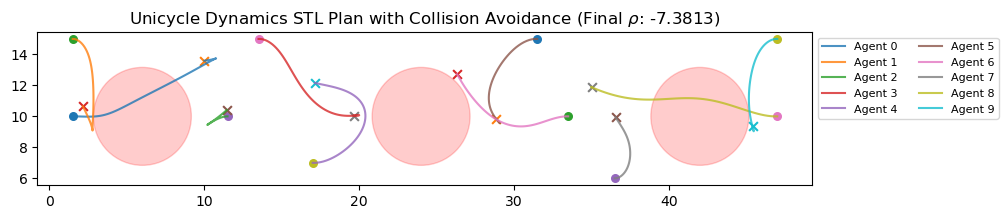

In [3]:
Xall_final = np.array(vmap(simulate_agent_scan)(x0_list, U))
fig, ax = plt.subplots(figsize=(10, 8))
for c, r in zip(O_centers, r_obs):
    ax.add_patch(patches.Circle(c, r, color='red', alpha=0.2))

for i in range(num_agents):
    ax.plot(Xall_final[i, 0, :], Xall_final[i, 1, :], label=f'Agent {i}', alpha=0.8)
    ax.scatter(Xall_final[i, 0, 0], Xall_final[i, 1, 0], marker='o', s=30)
    ax.scatter(Xall_final[i, 0, -1], Xall_final[i, 1, -1], marker='x', s=40)

ax.set_aspect('equal')
ax.set_title(f"Unicycle Dynamics STL Plan with Collision Avoidance (Final $\\rho$: {rho_hist[-1]:.4f})")
plt.legend(ncol=2, fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

def animate_trajectories(Xall, O_centers, r_obs, filename="trajectories.gif"):
    num_agents, _, total_steps = Xall.shape
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(jnp.min(Xall[:, 0, :]) - 2, jnp.max(Xall[:, 0, :]) + 2)
    ax.set_ylim(jnp.min(Xall[:, 1, :]) - 2, jnp.max(Xall[:, 1, :]) + 2)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

    # 1. Draw Static Obstacles
    for c, r in zip(O_centers, r_obs):
        ax.add_patch(plt.Circle(c, r, color='red', alpha=0.3))

    # 2. Initialize dynamic elements
    # Lines for the trailing path and Dots for current position
    lines = [ax.plot([], [], lw=1.5, alpha=0.6)[0] for _ in range(num_agents)]
    dots = [ax.plot([], [], 'o', markersize=6)[0] for _ in range(num_agents)]
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

    def init():
        for line, dot in zip(lines, dots):
            line.set_data([], [])
            dot.set_data([], [])
        time_text.set_text('')
        return lines + dots + [time_text]

    def update(frame):
        for i in range(num_agents):
            # Trail from start to current frame
            lines[i].set_data(Xall[i, 0, :frame], Xall[i, 1, :frame])
            # Current position dot
            dots[i].set_data([Xall[i, 0, frame]], [Xall[i, 1, frame]])
        
        time_text.set_text(f'Time Step: {frame}')
        return lines + dots + [time_text]

    # 3. Create Animation
    # blit=True makes it faster, interval is ms between frames
    ani = FuncAnimation(fig, update, frames=total_steps, 
                        init_func=init, blit=True, interval=50)

    # 4. Save as GIF
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.close() # Prevents extra static plot from appearing
    
    # 5. Display in Jupyter
    display(Image(filename=filename))

# Run the function
animate_trajectories(Xall_final, O_centers, r_obs)